In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
import random
import cv2
import time
from collections import Counter
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

from keras.preprocessing import image
from keras.utils import to_categorical
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.models import Model, Sequential
from keras import metrics
from keras import regularizers
from keras.utils import multi_gpu_model
import keras.backend as K
from keras.callbacks import Callback, TensorBoard, EarlyStopping
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import tensorflow as tf

# 1. Load Data
## 1.1 Train labels

In [2]:
df = pd.read_csv("labels.csv")
df_valid = df.loc[int(len(df.index) * 0.8):]
df = df.loc[:int(len(df.index) * 0.8)]

nTrain = len(df.index)
nValid = len(df_valid.index)

print("Number of training samples:", nTrain)
print("Number of validation samples:", nValid)
df.head()

Number of training samples: 8178
Number of validation samples: 2045


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [3]:
breeds = list(set(df.breed))
breed_counts = dict(Counter(df.breed.values))

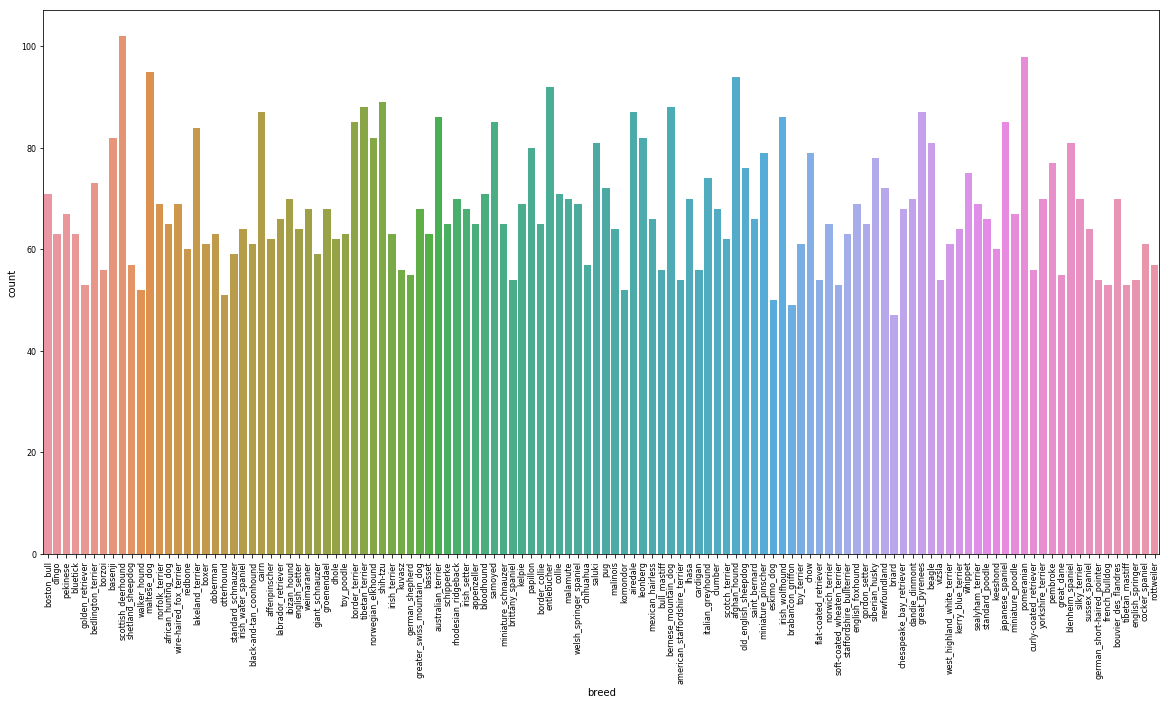

In [4]:
_= plt.figure(figsize=(20, 10))
g = sns.countplot(x="breed", data=df, orient='v')
g.set_xticklabels(g.get_xticklabels(), rotation="vertical");
g.tick_params(labelsize=8)

Less freq breed: affenpinscher counts: 47
Max freq breed: yorkshire_terrier counts: 102
Mean: 68, Std: 11.8



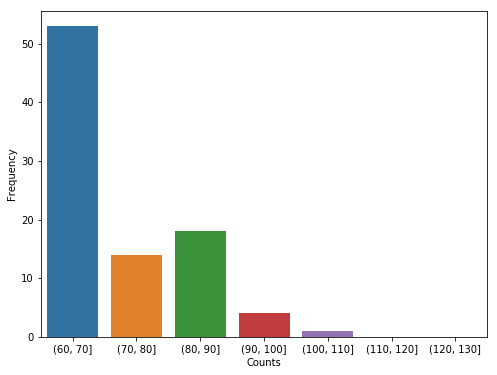

In [5]:
bins = list(range(60, 140, 10))

groups = df.groupby("breed").count().groupby(["breed", pd.cut(df.groupby("breed").count().id, bins)])
groups.size().unstack()
data = groups.size().unstack().sum().to_frame().reset_index().rename(columns={0: "Frequency", "id": "Counts"})

df_stats = df.groupby("breed").count().reset_index().rename(columns={"id": "counts"})
print("Less freq breed: {} counts: {}".format(df_stats.min().breed, df_stats.min().counts))
print("Max freq breed: {} counts: {}".format(df_stats.max().breed, df_stats.max().counts))
print("Mean: {}, Std: {:.1f}\n".format(int(df_stats.counts.mean()), float(df_stats.counts.std())))

_ = plt.figure(figsize=((8, 6)));
sns.barplot(x="Counts", y="Frequency", data=data);

## 1.2 Train examples

In [4]:
def read_image(img_path, size=(224, 224)):
    img = image.load_img(img_path, target_size=size)
    return image.img_to_array(img)

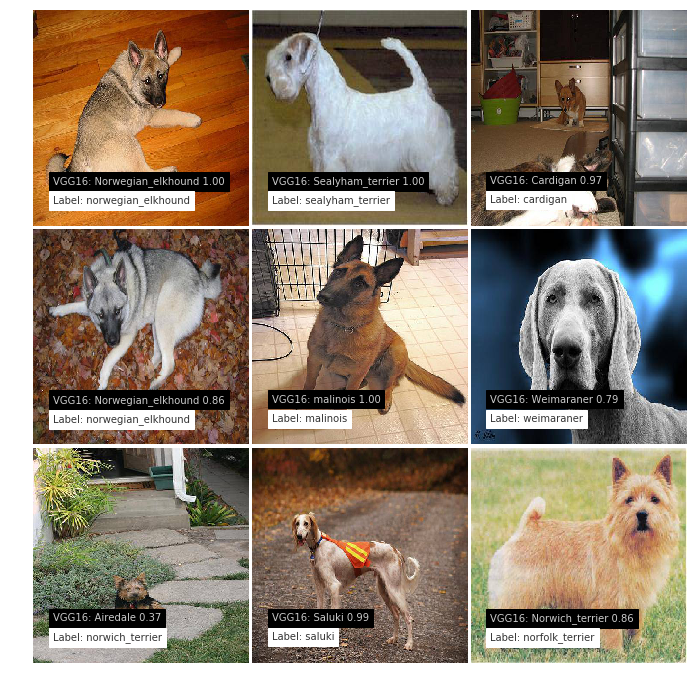

In [8]:
vgg = VGG16(weights="imagenet")

fig = plt.figure(1, figsize=(12, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 3), axes_pad=.05)

for i, row in df.sample(9, axis=0).reset_index().iterrows():
    ax = grid[i]
    img = read_image("train/{}/{}.jpg".format(row.breed, row.id))
    ax.imshow(img / 255.)
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    preds = vgg.predict(x)
    _, class_pred, score = decode_predictions(preds, 1)[0][0]
    ax.text(20, 180, "VGG16: {} {:.2f}".format(class_pred, float(score)), color='w', backgroundcolor='black', alpha=0.8)
    ax.text(20, 200, "Label: {}".format(row.breed), color='black', backgroundcolor="w", alpha=0.8)
    ax.axis("off")

# 2. Define Model

In [5]:
def preprocess_input_new(x):
    img = preprocess_input(image.img_to_array(x))
    return image.array_to_img(img)

## 2.1 Data Generator

In [6]:
batch_size = 512

train_datagen = ImageDataGenerator(
    rotation_range=40, 
    width_shift_range=.2, 
    height_shift_range=.2,
    shear_range=.2,
    zoom_range=.2,
    horizontal_flip=True,
    fill_mode="nearest",
    preprocessing_function=preprocess_input_new
)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_new)

train_generator = train_datagen.flow_from_directory("train/", target_size=(224, 224), batch_size=batch_size)
valid_generator = valid_datagen.flow_from_directory("valid/", target_size=(224, 224), batch_size=batch_size)

Found 8180 images belonging to 120 classes.
Found 2048 images belonging to 120 classes.


## 2.2 Load pre-trained Features

In [ ]:
vgg_convs = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3), pooling='max')
valid_features = vgg_convs.predict_generator(train_generator, 
                                             verbose=1, 
                                             steps=train_generator.n // batch_size)



In [7]:
def pre_train_processing(generator):
    vgg_convs = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    
    features = np.zeros(shape=(generator.n, 7, 7, 512))
    labels = np.zeros(shape=(generator.n, 120))
    i = 0
    for inputs_batch, labels_batch in tqdm(generator):
        features_batch = vgg_convs.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= generator.n:
            break
    return np.reshape(features, (generator.n, 7 * 7 * 512)), labels

train_features, train_labels = pre_train_processing(train_generator)
valid_features, valid_labels = pre_train_processing(valid_generator)

In [8]:
np.save("train_features.npy", train_features)
np.save("train_labels.npy", train_labels)
np.save("valid_features.npy", valid_features)
np.save("valid_labels.npy", valid_labels)

## 2.3 Classifier Model

In [117]:
del model
model = Sequential()
model.add(Dense(4096, activation="relu", input_dim=7 * 7 * 512))
model.add(Dense(4096, activation="relu", kernel_regularizer=regularizers.l2(5e-4)))
model.add(Dropout(0.5))
model.add(Dense(120, activation="softmax"))

sgd = SGD(lr=1e-2, momentum=.9) 
model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 4096)              102764544 
_________________________________________________________________
dense_20 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dropout_8 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 120)               491640    
Total params: 120,037,496
Trainable params: 120,037,496
Non-trainable params: 0
_________________________________________________________________


In [118]:
class LrDecay(Callback):
    def __init__(self, min_delta=0):
        super(Callback, self).__init__()
        self.min_delta = min_delta
        self.val_acc = []
       
        
    def on_epoch_end(self, epoch, logs={}):
        if epoch > 0:
            if logs["val_acc"] - self.val_acc[-1]  <= self.min_delta:
                lr = K.get_value(self.model.optimizer.lr)
                K.set_value(self.model.optimizer.lr, lr / 10)
                print("Lr decreased by 10.")
        
        self.val_acc.append(logs["val_acc"])
    

class TensorBoardLr(TensorBoard):
    def __init__(self, log_every=1, **kwargs):
        super().__init__(**kwargs)
        self.log_every = log_every
        self.counter = 0
    
    def on_epoch_end(self, epoch, logs=None):
        
        logs = logs or {}
        
        summary = tf.Summary()
        summary_value = summary.value.add()
        summary_value.simple_value = float(format(K.get_value(self.model.optimizer.lr), ".2g"))
        summary_value.tag = "Learning rate"
        self.writer.add_summary(summary, epoch)
        self.writer.flush()
        
        super().on_epoch_end(epoch, logs)

In [119]:
now = time.strftime("%Y%m%d_%H%M%S")

tensorboard = TensorBoard(log_dir="logs/" + now, write_graph=True)
early_stopping = EarlyStopping(monitor="val_loss", patience=50, min_delta=0.1)
lr_decay = LrDecay()
tb = TensorBoardLr(log_dir="logs/" + now)

history = model.fit(train_features,
                    train_labels, epochs=5000, 
                    steps_per_epoch=16,
                    validation_steps=4,
                    validation_data=(valid_features, valid_labels),
                    callbacks=[tb, early_stopping, lr_decay], 
                    verbose=1)

Train on 8180 samples, validate on 2048 samples
Epoch 1/5000
16/16 [==============================] - 39s 2s/step - loss: 14.2369 - acc: 0.1782 - val_loss: 10.9967 - val_acc: 0.2729
Epoch 2/5000
16/16 [==============================] - 37s 2s/step - loss: 4.5249 - acc: 0.7476 - val_loss: 6.0434 - val_acc: 0.3745
Epoch 3/5000
16/16 [==============================] - 37s 2s/step - loss: 2.1176 - acc: 0.9843 - val_loss: 5.8489 - val_acc: 0.4199
Epoch 4/5000
16/16 [==============================] - 37s 2s/step - loss: 2.0476 - acc: 0.9972 - val_loss: 5.8092 - val_acc: 0.4219
Epoch 5/5000
16/16 [==============================] - 37s 2s/step - loss: 2.0344 - acc: 0.9986 - val_loss: 5.7634 - val_acc: 0.4360
Epoch 6/5000
16/16 [==============================] - 36s 2s/step - loss: 2.0262 - acc: 0.9992 - val_loss: 5.7435 - val_acc: 0.4316
Lr decreased by 10.
Epoch 7/5000
16/16 [==============================] - 36s 2s/step - loss: 2.0202 - acc: 0.9993 - val_loss: 5.7371 - val_acc: 0.4331
Epoch 

KeyboardInterrupt: 

# 4. Predictions

In [120]:
def encode_label(breed, generator):
    y_true = np.zeros((1, 120))
    y_true[0][generator.class_indices[breed]] = 1.
    return y_true

def decode_prediction(y_pred, generator):
    reversed_class_indeces = dict(map(reversed, generator.class_indices.items()))
    class_pred = reversed_class_indeces[np.argmax(y_pred)]
    score = y_pred.max(axis=1)
    return class_pred, score

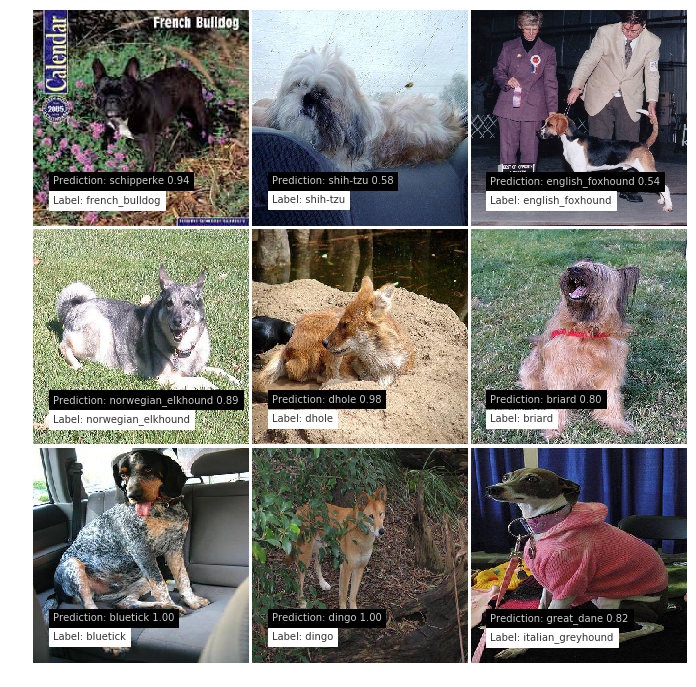

In [121]:
fig = plt.figure(3, figsize=(12, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 3), axes_pad=.05)
vgg_convs = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for i, row in df_valid.sample(9, axis=0).reset_index().iterrows():
    ax = grid[i]
    img = read_image("valid/{}/{}.jpg".format(row.breed, row.id))
    ax.imshow(img / 255.)
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    x = vgg_convs.predict(x)
        
    y_pred = model.predict(x=x.reshape(1, 7 * 7 * 512))
    class_pred, score = decode_prediction(y_pred, valid_generator)

    ax.text(20, 180, "Prediction: {} {:.2f}".format(class_pred, float(score)), color='w', backgroundcolor='black', alpha=0.8)
    ax.text(20, 200, "Label: {}".format(row.breed), color='black', backgroundcolor="w", alpha=0.8)
    ax.axis("off")

In [127]:
one_hot = pd.get_dummies(df["breed"], sparse=True)
np.asarray(one_hot).shape

(8178, 120)